# Make Transects (interactive)

This notebook illustrates how to make transects of event results that can be interactively updated by selecting the transect.  


### First set up some things needed in notebook....

In [24]:
%pylab inline
%matplotlib notebook

Populating the interactive namespace from numpy and matplotlib


In [19]:
import sys, os
from ipywidgets import interact
from IPython.display import Image, display

codes_dir = os.path.abspath('../PythonCode')
sys.path.append(codes_dir)
print "Python codes can be found in %s"  % codes_dir

data_dir = os.path.abspath('../DataFiles')
print "Data files can be found in %s"  % data_dir

events_dir = os.path.join(data_dir, 'Events')
print "Results for each event can be found in %s"  % events_dir

Python codes can be found in /Users/rjl/git/ptha_tutorial/PythonCode
Data files can be found in /Users/rjl/git/ptha_tutorial/DataFiles
Results for each event can be found in /Users/rjl/git/ptha_tutorial/DataFiles/Events


### Read in the topography data and define a function to make a contour plot:

In [20]:
# Read in topography data:

fixed_grid_file = os.path.join(data_dir, 'MapsTopo', 'fixedgrid_xyB_small.npy')
d=load(fixed_grid_file)
x=d[:,0]
y=d[:,1]
B=d[:,2]
topo = reshape(B, (250,250), order='F')
X = reshape(x, (250,250), order='F')
Y = reshape(y, (250,250), order='F')

def plot_topo():
    fig = figure(figsize=(6,6))
    ax = axes()
    topo_clines = arange(0,20,2)
    contour(X,Y,topo,topo_clines,colors='k')
    CClatitude = 41.75  # to rescale longitude
    ax.set_aspect(1. / cos(pi*CClatitude/180.)) 
    ax.ticklabel_format(format='plain',useOffset=False)
    return fig

## Define class to allow interactive plotting

The class `DrawLine` allows the reader to select a transect and will then interpolate the solution from the specified event to this transect.

We first define a function `topo_func` that allows us to evaluate the topography at any point `(x,y)`.

The function `plot_transect` is then defined to take two points `(x1,y1)` and `(x2,y2)` and interpolate the topography onto a set of 1000 equally spaced points along the transect (straight line connecting the points).  The function also takes another argument, a `z_func` function that can also be evaluated at any point and is assumed to return a value of $\zeta$ at this point.  This might be defined to be the `zeta` for a particular single event, or it might be the `zeta` coming from a probabilistic analysis at some particular probability `p`.  


In [30]:
from scipy.interpolate import RegularGridInterpolator
topo_func = RegularGridInterpolator((X[:,0], Y[0,:]), topo)

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

class DrawLine:
    def __init__(self, line,zeta,topo):
        self.line = line
        self.figure = line[0].figure
        self.xprev = 0
        self.yprev = 0
        self.xnew = 0
        self.ynew = 0
        self.press = None
        self.zeta = zeta
        self.topo = topo

    def connect(self):
        'connect to all the events we need'
        self.cidpress = self.figure.canvas.mpl_connect(
            'button_press_event', self.on_press)
        self.cidrelease = self.figure.canvas.mpl_connect(
            'button_release_event', self.on_release)

    def on_press(self, event):
        self.xprev = event.xdata
        self.yprev = event.ydata
        self.press = 1
        ax1.plot(self.xprev,self.yprev,'ro')
        self.figure.canvas.draw()
        #self.line[0].set_data([[event.xdata],[event.ydata]])
        #self.line[0].set_xdata = np.array([event.xdata, self.line[0].get_xdata()[1]])
        #self.line[0].set_ydata = np.array([event.ydata, self.line[0].get_ydata()[1]])

    def on_release(self, event):
        self.press = None
        self.xnew = event.xdata
        self.ynew = event.ydata
        #self.line[0].set_xdata = np.array([self.line[0].get_xdata()[0]], event.xdata)
        #self.line[0].set_ydata = np.array([self.line[0].get_ydata()[0]], event.ydata)
        ax1.cla()
        
        topo_clines = arange(0,20,2)
        ax1.contour(X,Y,topo,topo_clines,colors='k')
        CClatitude = 41.75  # to rescale longitude
        ax1.set_aspect(1. / cos(pi*CClatitude/180.)) 
        ax1.ticklabel_format(format='plain',useOffset=False)
    
        ax1.plot(self.xprev,self.yprev,'ro')
        ax1.plot([self.xprev,self.xnew],[self.yprev,self.ynew],'-r',lw=3)
        #ax1.set_xlim(-5,5)
        #ax1.set_ylim(-5,5)
        
        self.plot_transect()
        self.figure.canvas.draw()

    def disconnect(self):
        'disconnect all the stored connection ids'
        self.figure.canvas.mpl_disconnect(self.cidpress)
        self.figure.canvas.mpl_disconnect(self.cidrelease)
        
    def plot_transect(self):
        # points on transect:
        xi = linspace(self.xprev, self.xnew, 1000)
        yi = linspace(self.yprev, self.ynew, 1000)
        
        # evaulate topo and zeta on transect:
        Bi = self.topo(zip(xi,yi))
        zi = self.zeta(zip(xi,yi))
        
        ax2.set_title('asd')
        
        # define eta as zeta offshore or zeta + topo onshore:
        eta = where(Bi<0, zi, zi+Bi)
    
        # Clear axis 2
        ax2.cla()
    
        # plot vs. longitude or latitude depending on orientation:
        if (abs(self.xnew-self.xprev) > 0.5*abs(self.ynew-self.yprev)):
            ti = xi
            ax2.set_xlim(min(self.xprev,self.xnew),max(self.xprev,self.xnew))
            xtext = 'longitude'
        else:
            ti = yi
            ax2.set_xlim(min(self.yprev,self.ynew),max(self.yprev,self.ynew))
            xtext = 'latitude'
            
        Bi0 = where(Bi<0, 0., Bi) #where(Bi<0, -2., Bi) #where(Bi<0, 0., Bi)
        
        
        ax2.fill_between(ti, Bi0, eta, color='b')
        ax2.plot(ti, Bi, 'g', lw=3)
        
        ax2.set_xlabel(xtext)
        ax2.set_ylabel('meters')
        ax2.set_title('Elevation vs. %s' % xtext)
    
        # choose limits of vertical axis to give nice plots:
        eta_wet_max = where(zi>0, zi+Bi, 0).max()
        ax2.set_ylim(0, max(6,eta_wet_max))
    
        ax2.ticklabel_format(format='plain',useOffset=False)
        ax1.set_title('(%8.4f,%8.4f) to (%8.4f,%8.4f)' % (self.xprev,self.yprev,self.xnew,self.ynew))

## Select an event and execute to start the interactive plot...

Event: AASZb


<IPython.core.display.Javascript object>


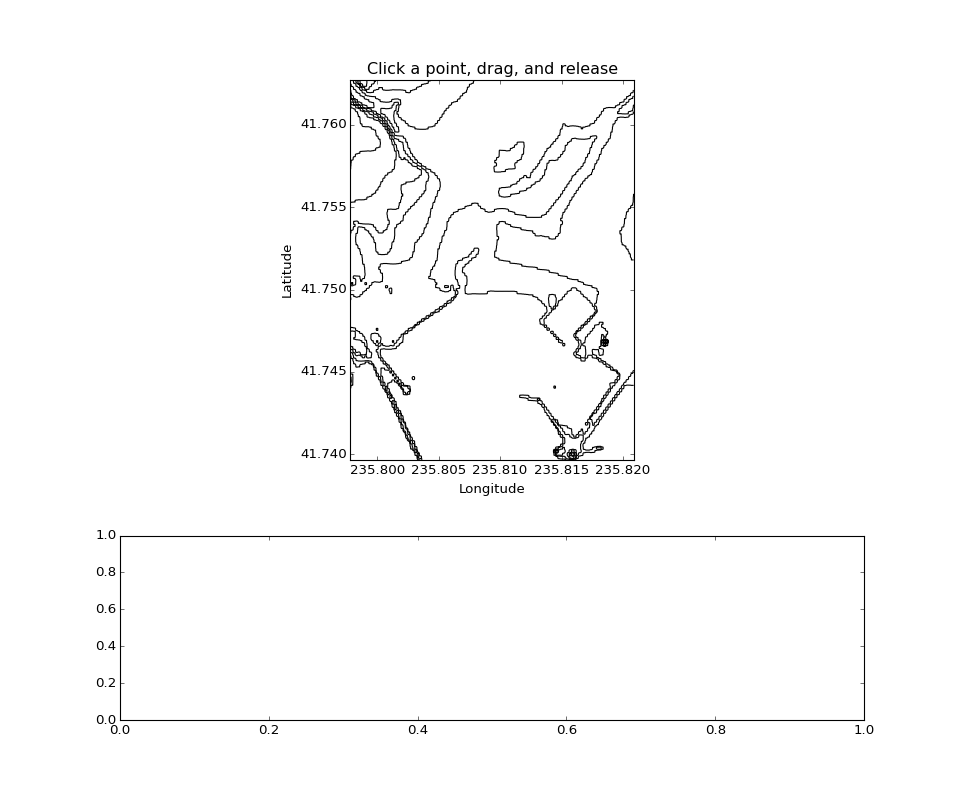

In [31]:
event = 'AASZb'

event_dir = os.path.join(events_dir, event)
hmax_file = os.path.join(event_dir, 'h_eta_small.npy')
hmax = load(hmax_file)
Hmax = hmax.reshape((250,250),order='F')
zeta_event_func = RegularGridInterpolator((X[:,0], Y[0,:]), Hmax)
print("Event: %s" % event)


gs = gridspec.GridSpec(10, 3)
fig = plt.figure(figsize=(12,10))
ax1 = plt.subplot(gs[0:6,0:]) #fig.add_subplot(121)
ax2 = plt.subplot(gs[7:,0:]) #fig.add_subplot(122)

topo_clines = arange(0,20,2)
ax1.contour(X,Y,topo,topo_clines,colors='k')
CClatitude = 41.75  # to rescale longitude
ax1.set_aspect(1. / cos(pi*CClatitude/180.)) 
ax1.ticklabel_format(format='plain',useOffset=False)
ax1.axis(extent, aspect=0.1)
ax1.set_xlabel("Longitude")
ax1.set_ylabel("Latitude")
ax1.set_title("Click a point, drag, and release")

#ax2.set_xlim(-5,5)
#ax2.set_ylim(-2,2)

points = ax1.plot([1],[10], '-k', lw=3)
dr =  DrawLine(points,zeta_event_func,topo_func)
dr.connect()